## processing notebook that takes several models and calculates , plots, compares carbon flux. first cell has inputs, to change if necessary



In [1]:
%reset
bd = '/gpfs/home/mep22dku/scratch/ModelRuns/'
ad = '/gpfs/afm/greenocean/software/runs/'

#runs to extract - may not be all runs to plot

trs = ['TOM12_TJ_1AS6', 'TOM12_DW_WE43']
bds = [ad, ad]
labs = ['1AS6- hist ozone, ssp1-2.6 chloro feedback on',
        'WD43 - dave CORE dynamics run']

forced_mins = ['1948','1948','1948','1948']
colors = ['red','blue','green',]

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import glob
import warnings
import sys
warnings.filterwarnings('ignore')
import argparse
from argparse import RawTextHelpFormatter
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import utils as ut
import xarray as xr
import re
import time

In [3]:
def make_yearlist(yrst, yrend, dtype, tr, baseDir):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def max_min_yrs(tr, baseDir):
    w = glob.glob(f'{baseDir}{tr}/ORCA2_1m_*ptrc*.nc')
    yrs = []
    for i in range(0,len(w)):
        ts = (w[i])
        pattern = f'{baseDir}{tr}/ORCA2_1m_'
        mod_string = re.sub(pattern, '', ts)
        yrs.append(int(mod_string[0:4]))
        
    tmin = min(yrs); tmax = max(yrs)
    return tmin, tmax

def weighted_temporal_mean(tvar):
    """
    weight by days in each month - get a yearly mean value for a quantity
    https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    original had stuff about nans, we don't
    """
    # Determine the month length
    month_length = tvar.time_counter.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time_centered.year") / month_length.groupby("time_centered.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time_centered.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = tvar

    # Calculate the numerator annual
    obs_sum = (obs * wgts).resample(time_counter="A").sum(dim="time_counter")

    return obs_sum 


def get_yrs_and_cflx(tr, baseDir = '/gpfs/home/mep22dku/scratch/ModelRuns/', forcedmin = False, fm = 0):
    '''
    uses previous 3 fxns - get maxs and mins in timeseries,
    get year list 
    get weighted temporal mean and years
    
    '''
    w = time.time()
    #find max and min years in TS
    tmin, tmax = max_min_yrs(tr, baseDir)
    if forcedmin:
        tmin = fm;
    #get filelist for TS - diad for cflx
    t_yearlist = make_yearlist(tmin,tmax,'diad',tr, baseDir)
    #open whole ts as one mfdataset
    t_ds = xr.open_mfdataset(t_yearlist)

    #open the meshmask file
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    #cflx is in mol/m2/s, multiply by m2 in meshmask to get mol/s
    cflx_mol_s = t_ds['Cflx']*tmesh['csize']

    t_yearly = weighted_temporal_mean(cflx_mol_s)

    #seconds in year
    siy = 60*60*24*365
    pg_in_mol = 12 * 1e-15

    cflx_pg_yr = (np.nansum(np.nansum(t_yearly*siy*pg_in_mol, axis = 2), axis = 1))
    
    #get years out
    yrs = cflx_mol_s.groupby('time_counter.year').mean('time_counter').year.values
    t_ds.close()
    w2 = time.time()
    print(w2-w)
    return yrs, cflx_pg_yr

In [4]:


yr_ar = []
flx_ar = []
for i in range(0,len(trs)):

    tr = trs[i]
    yrs, cflx_pg_yr = get_yrs_and_cflx(tr, baseDir = bds[i], forcedmin = True, fm = 1948)
    yr_ar.append(yrs)
    flx_ar.append(cflx_pg_yr)
    

    

43.39901661872864
26.82164430618286
41.65707540512085
32.09512400627136


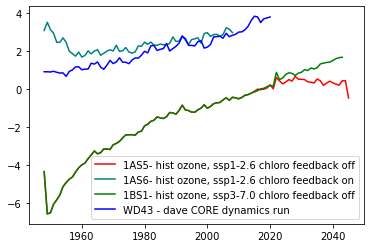

In [5]:


for i in range(0, len(yr_ar)):
    
    plt.plot(yr_ar[i], flx_ar[i], color = colors[i], label = labs[i])
plt.legend(loc = 'best')

In [6]:
np.shape(yr_ar)

(4,)

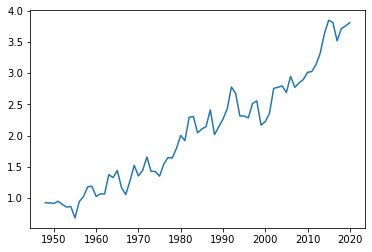

In [7]:
plt.plot(yrs,cflx_pg_yr)

In [8]:
# cflx_mol_s['time_centered'].sel('time_centered' = 1)




In [9]:
monthly_avr2.year.values

NameError: name 'monthly_avr2' is not defined